In [1]:
import sys
print("Python version")
print (sys.version)

Python version
3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import json
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from smiles_featurizers import morgan_fingerprints, mac_keys_fingerprints, one_hot_encode,morgan_fingerprints_mac_and_one_hot, morgan_fingerprints_and_one_hot
from utils import get_data_dictionaries, save_dict, plot_history, predictions_scatter_plot, save_model, calculate_metrics, get_smiles_dict, predictions_heat_map

In [3]:
# Parameters

 
path_to_all_smiles = "/Users/abdulsalamyazid/Desktop/thesis/Projects/Predicting Docking Scores/Data Set/Target1/all_smiles.txt"
PATH_TO_CSV = "/Users/abdulsalamyazid/Desktop/thesis/Projects/Predicting Docking Scores/Data Set/Target1/all_smiles_clean.csv"
# main dataset
# Program Variables
identifier = "10K"
TRAINING_SIZE = 10000
TESTING_SIZE = 50000
feature_dim= 3531 
int2char, char2int, dict_size = get_smiles_dict(path_to_all_smiles)


In [4]:
DATA = pd.read_csv(PATH_TO_CSV)


train_dict, test_dict = get_data_dictionaries(
    DATA, TRAINING_SIZE, TESTING_SIZE=TESTING_SIZE)
TESTING_SIZE = len(test_dict)

print("training size ", TRAINING_SIZE)
print("testing size ", TESTING_SIZE)

training size  10000
testing size  50000


In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(feature_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu((self.fc2(x)))
        x = F.relu((self.fc3(x)))
        x = F.relu((self.fc4(x)))

        x = self.fc5(x)

        return x

In [6]:
class Training(Dataset):

    def __init__(self, data_dict):
        self.data_dict = data_dict

    def __len__(self):
        return len(self.data_dict)

    def __getitem__(self, idx):
        data = self.data_dict[idx]
        smile = data[1]
        score = data[0]
        features = morgan_fingerprints_mac_and_one_hot(smile,char2int,dict_size)
        features = torch.from_numpy(features.reshape(features.shape[0], 1))
        score = torch.tensor([score])
        return features, score

In [7]:
# Testing the dataloader
smiles_data_train = Training(train_dict)
smiles_data_test = Training(test_dict)

for i in range(len(smiles_data_train)):
    features, score = smiles_data_train[i]

    print(i, features.shape, score)

    if i == 3:
        break

0 torch.Size([3531, 1]) tensor([-5.7000])
1 torch.Size([3531, 1]) tensor([-7.8000])
2 torch.Size([3531, 1]) tensor([-5.8000])
3 torch.Size([3531, 1]) tensor([-8.2000])


In [8]:
train_dataloader = DataLoader(
    smiles_data_train, batch_size=128, shuffle=True, num_workers=7)
test_dataloader = DataLoader(
    smiles_data_test, batch_size=128, shuffle=True, num_workers=7)

In [9]:
def train(train_dataloader, model, criterion, optimizer, number_of_epochs):
    metrics_dict = {"training_mse": []}
    mse_array_train = []

    for epoch in range(number_of_epochs):
        running_loss = 0
        for i_batch, data in enumerate(train_dataloader, 0):

            optimizer.zero_grad()
            features, target = data
            features = features.squeeze()
            outputs = net(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            del features, outputs
            running_loss += loss.item()
        mse_array_train.append(running_loss / len(train_dataloader))
        print("Epoch: {}/{}.. ".format(epoch+1, number_of_epochs),
              "Training MSE: {:.3f}.. ".format(running_loss/len(train_dataloader)))

    metrics_dict["training_mse"] = mse_array_train
    return metrics_dict
    print("Finished training.")

In [10]:
number_of_epochs = 6
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()
start_time_train_val = time.time()
metrics_dict = train(train_dataloader, net, criterion,
                     optimizer, number_of_epochs)
training_validation_time = (time.time() - start_time_train_val) / 60
print("Training Time :", training_validation_time, " Minutes")

Epoch: 1/6..  Training MSE: 8.670.. 
Epoch: 2/6..  Training MSE: 0.295.. 
Epoch: 3/6..  Training MSE: 0.166.. 
Epoch: 4/6..  Training MSE: 0.131.. 
Epoch: 5/6..  Training MSE: 0.113.. 
Epoch: 6/6..  Training MSE: 0.102.. 
Training Time : 0.48418281475702923  Minutes


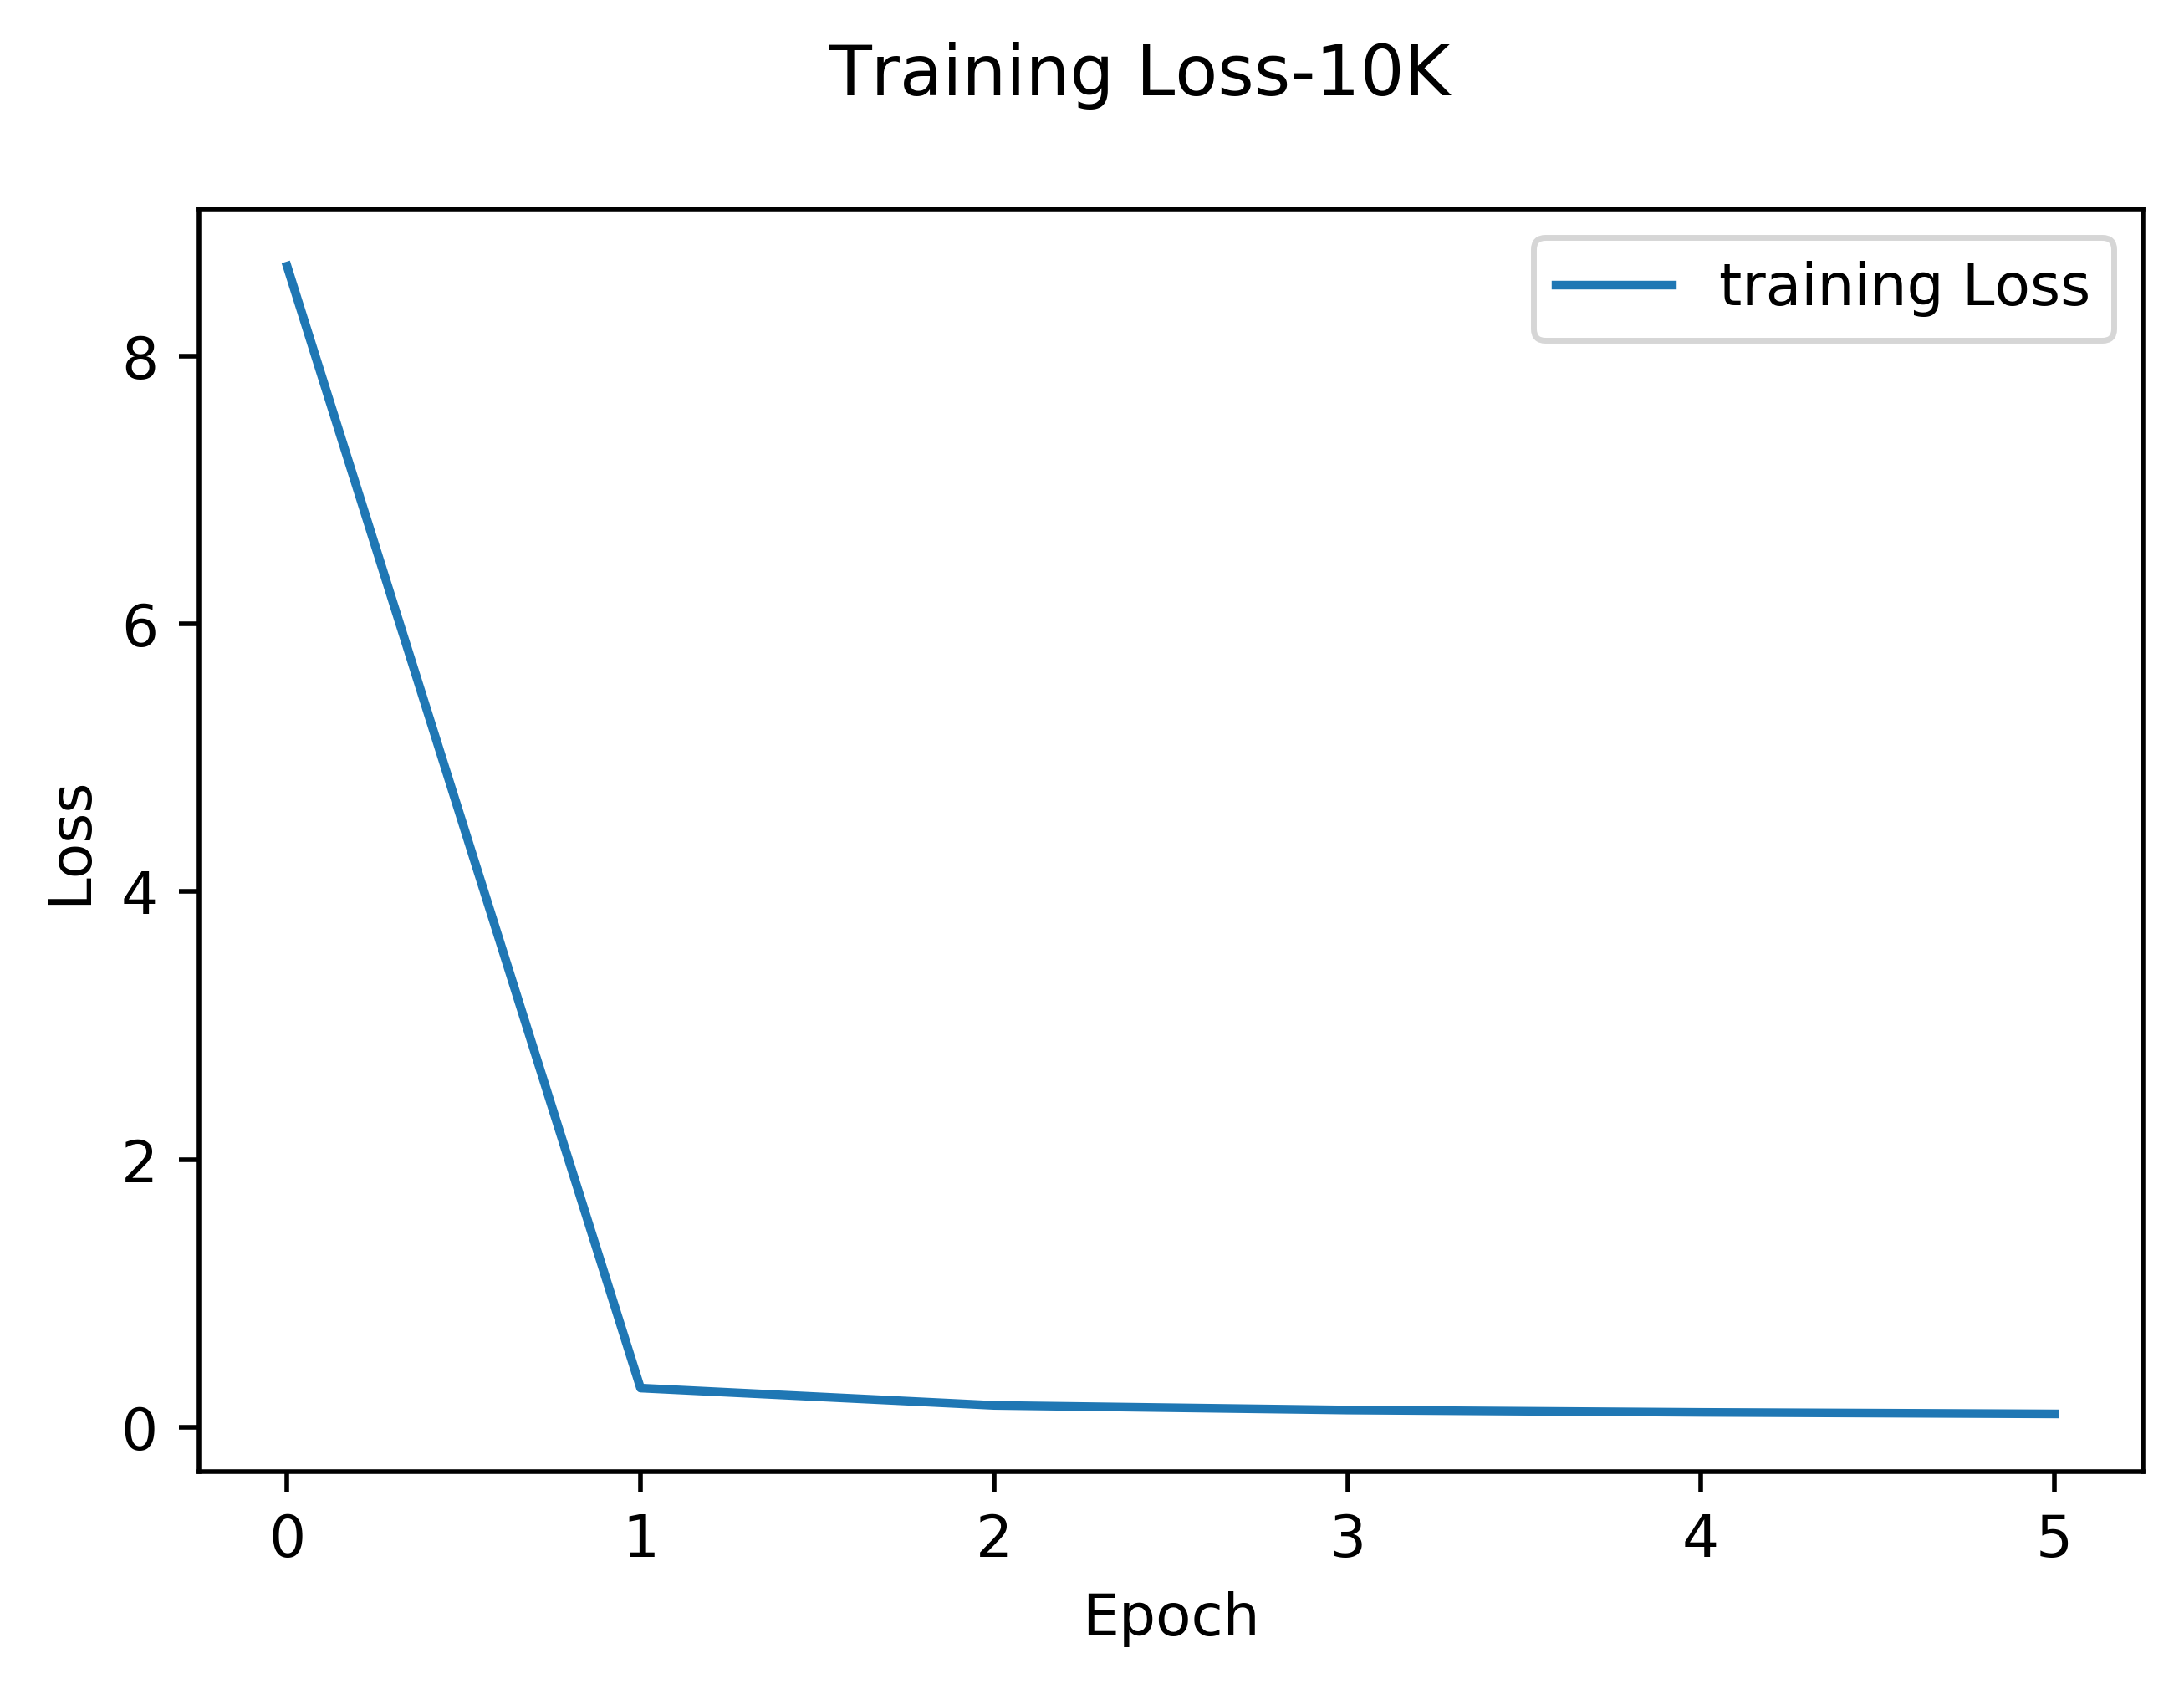

In [11]:
identifier_results_plot = identifier+"_train_plots"
identifier_train_val_metrics = identifier+"_train_metrics.csv"
identifier_model = identifier+".pt"
save_dict(metrics_dict, identifier_train_val_metrics)
save_model(net, optimizer, number_of_epochs, identifier_model)
plot_history(metrics_dict, identifier, identifier_results_plot)

In [12]:
def test(test_dataloader, net):
    smiles_prediction = []
    smiles_target = []
    metrics_dict_test = {"test_mse": [], "test_mae": [], "test_rsquared": []}
    test_predictions_and_target = {"predictions": [], "target": []}

    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            features, target = data
            features = features.squeeze()
            outputs = net(features)
            smiles_prediction.extend(outputs.squeeze().tolist())
            smiles_target.extend(target.squeeze().tolist())
            del features
            del target
        mse, mae, rsquared = calculate_metrics(
            smiles_prediction, smiles_target)
        metrics_dict_test["test_mse"].append(mse)
        metrics_dict_test["test_mae"].append(mae)
        metrics_dict_test["test_rsquared"] = rsquared
        test_predictions_and_target["predictions"] = smiles_prediction
        test_predictions_and_target["target"] = smiles_target
    return metrics_dict_test, test_predictions_and_target

In [13]:
start_time_test = time.time()
metrics_dict_test, test_predictions_and_target = test(test_dataloader, net)
test_time = (time.time() - start_time_test) / 60
print("Testing Time :", test_time, " Minutes")

RDKit WARNING: [14:02:30] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [14:02:30]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [14:02:30] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [14:02:30]   BondStereo set to STEREONONE and single bond directions set to NONE.


Testing Time : 0.3689005494117737  Minutes


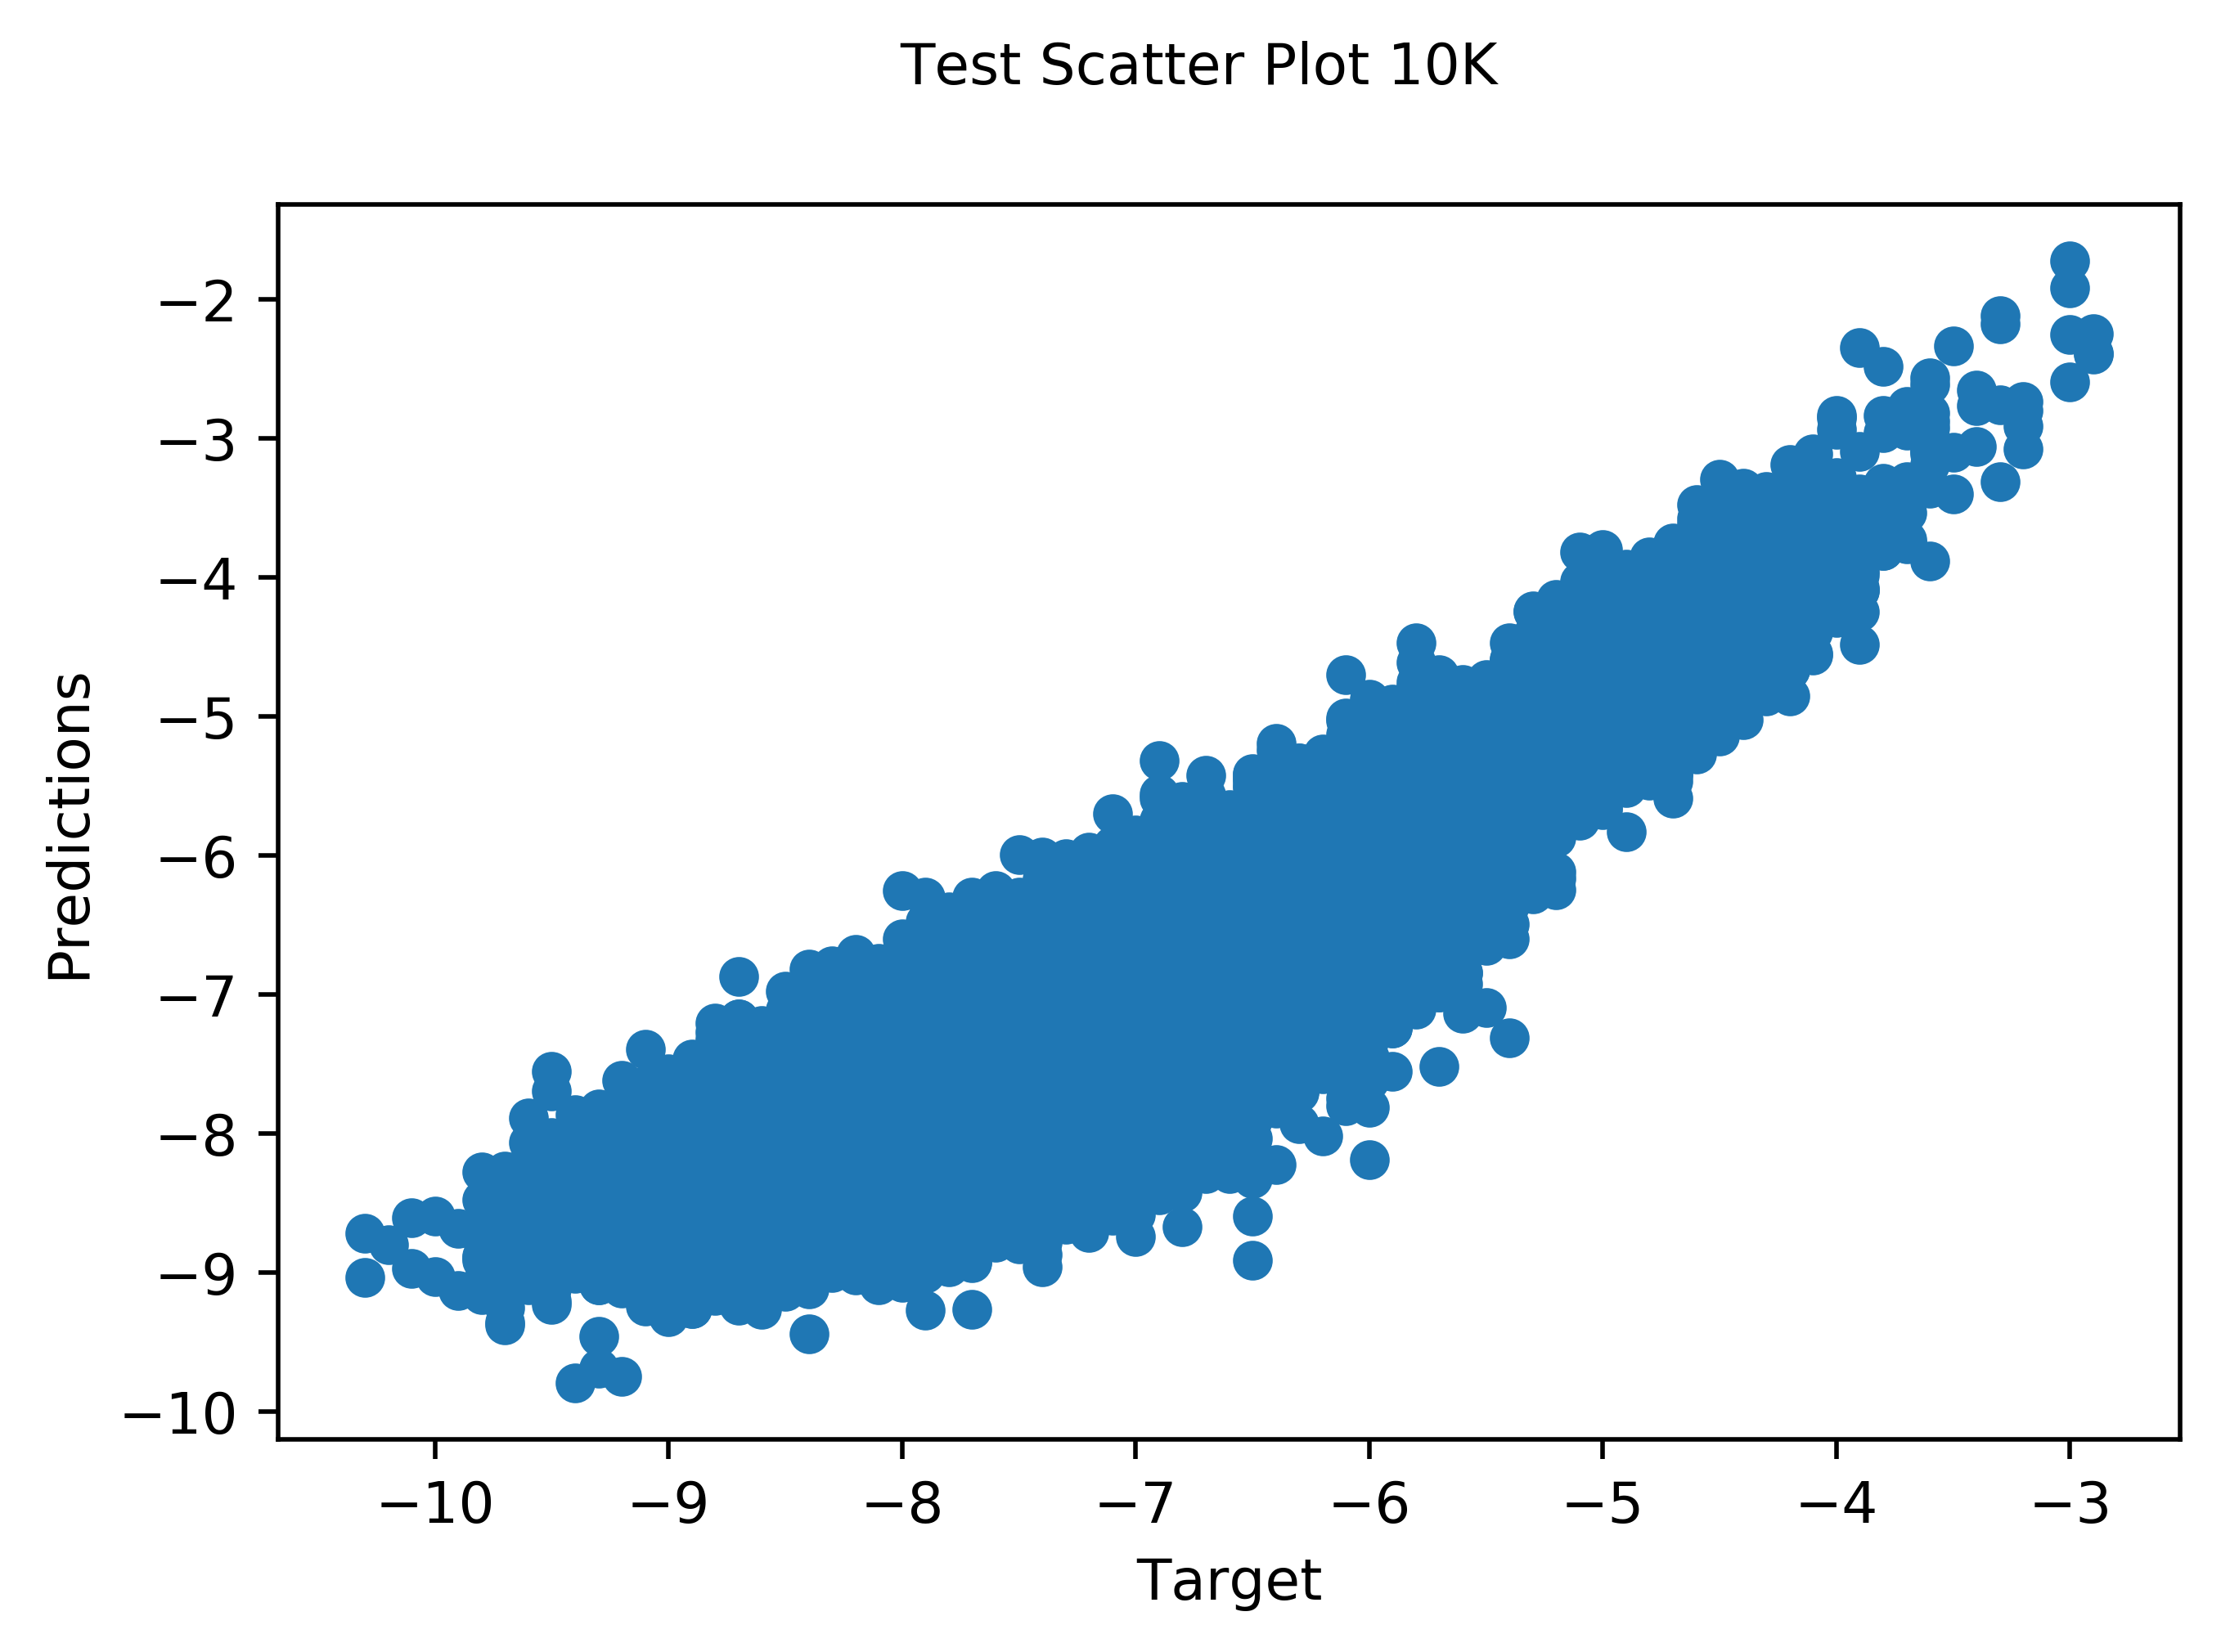

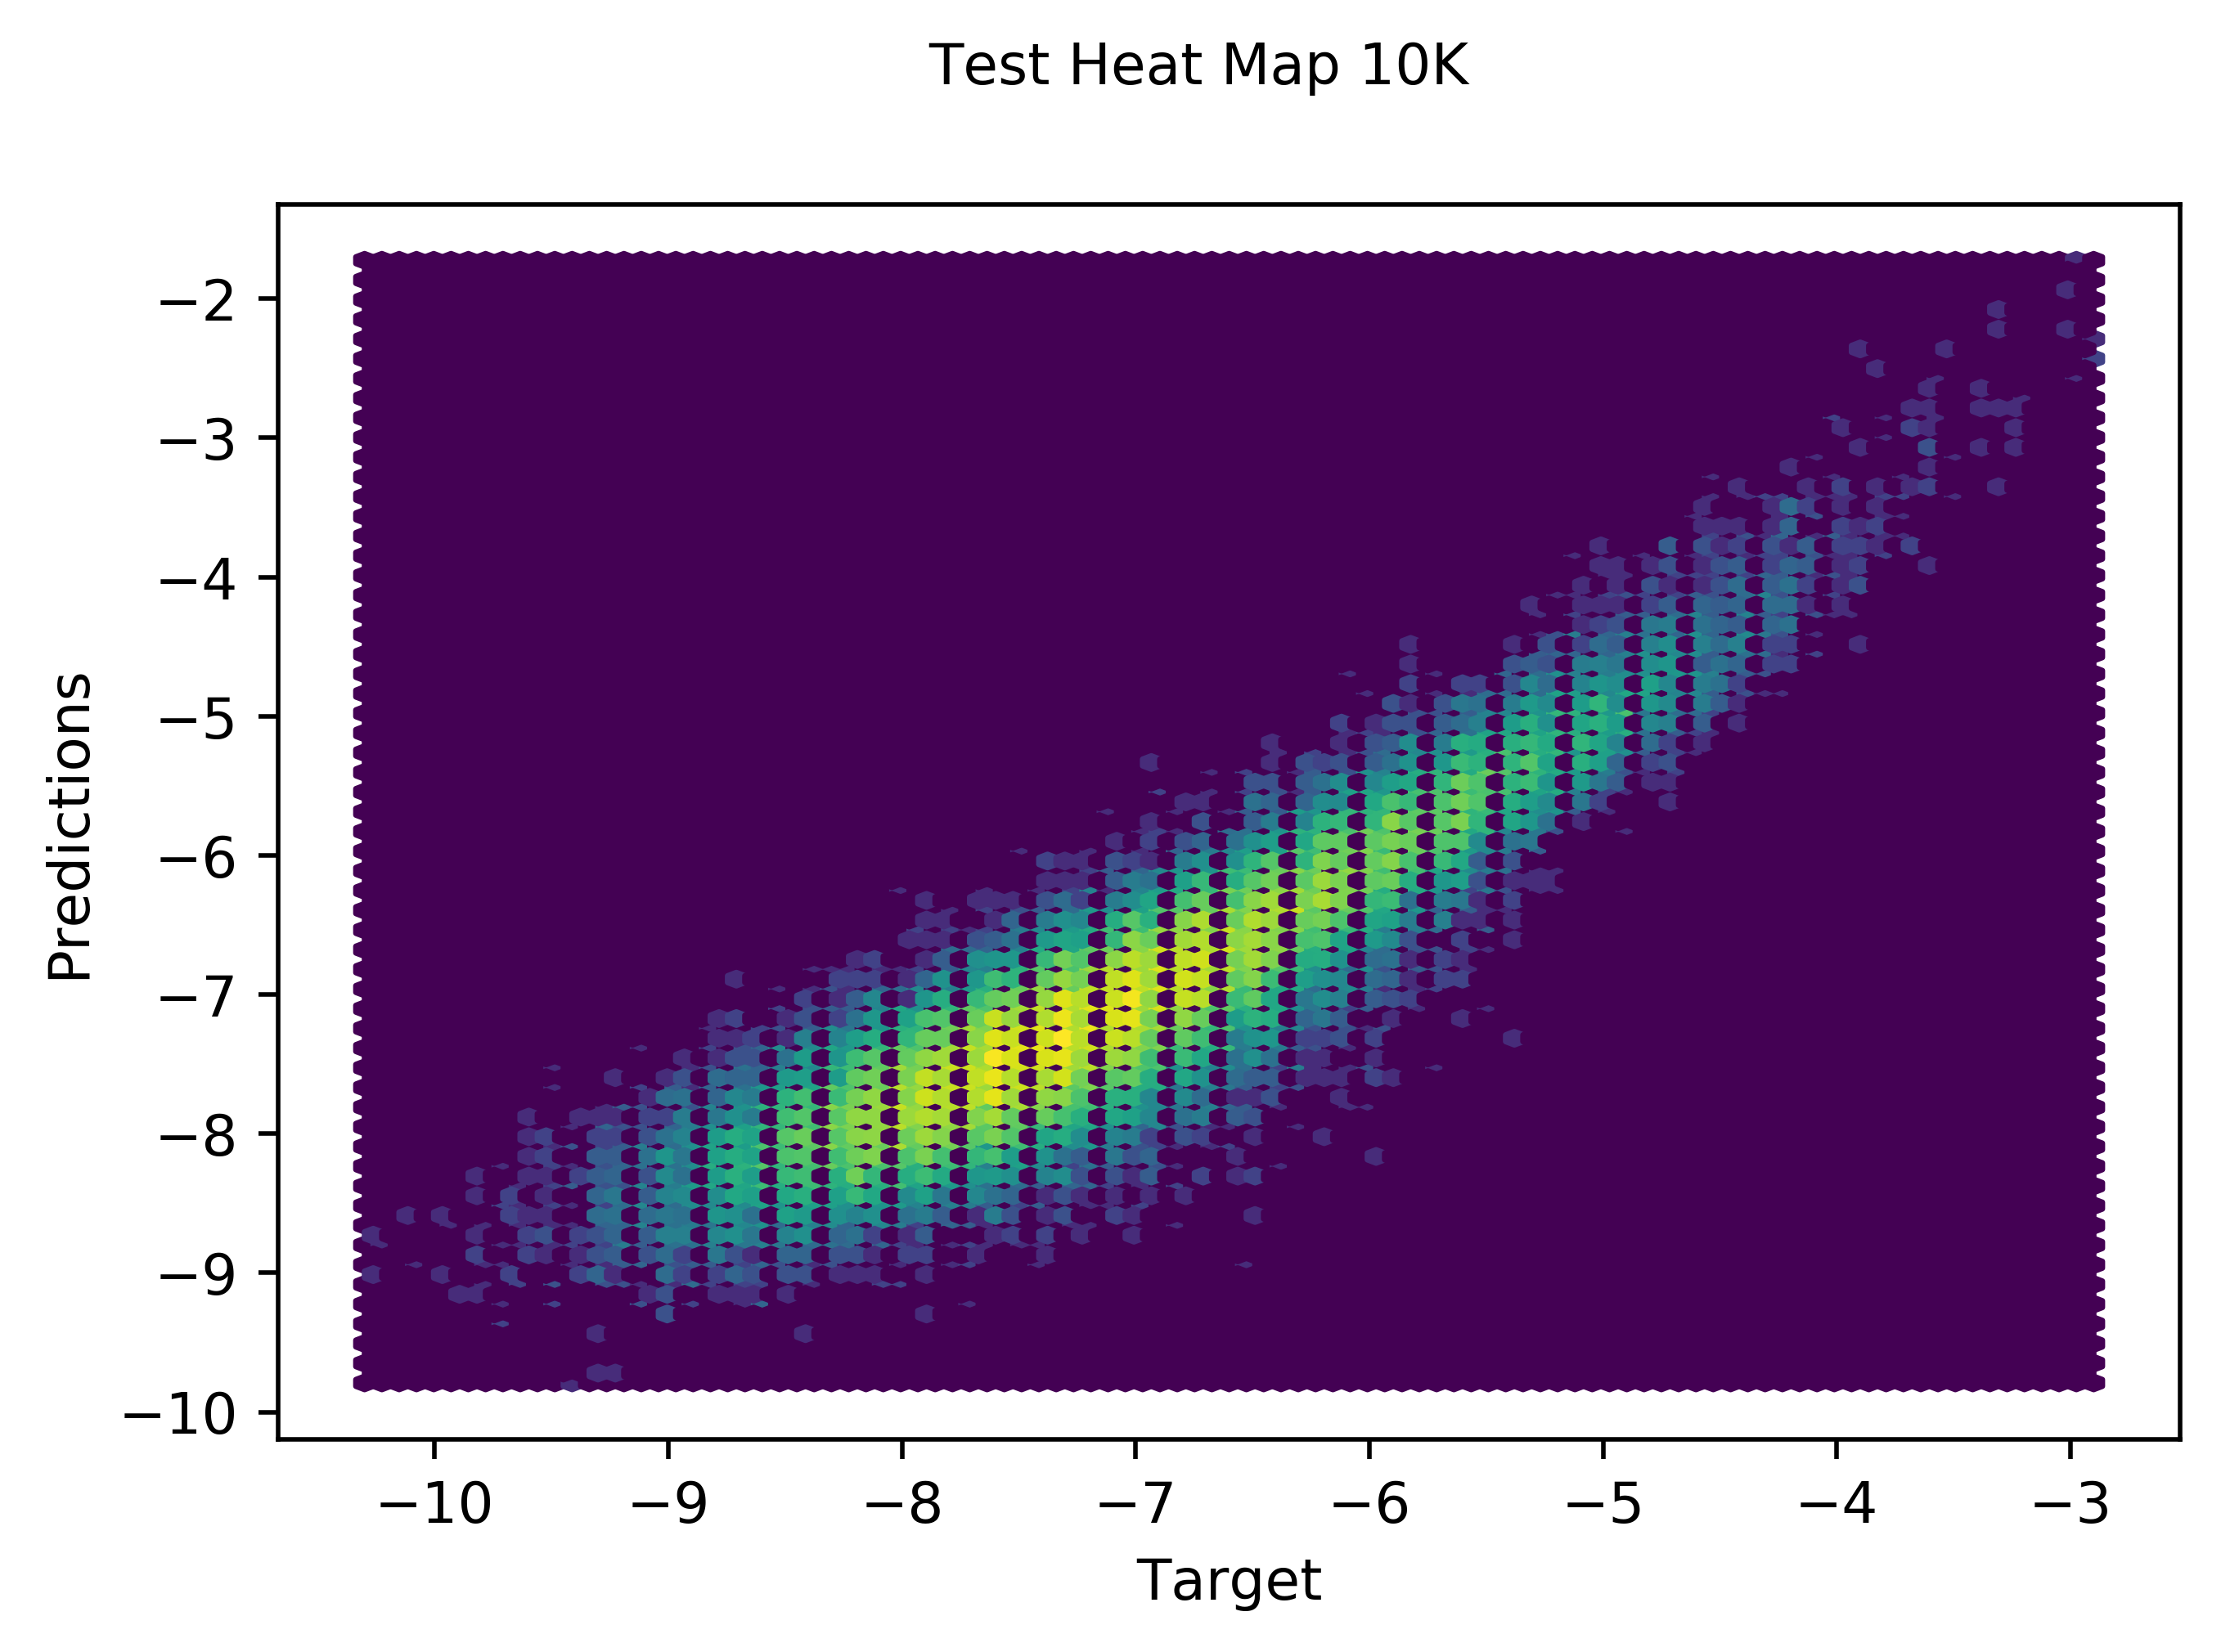

In [14]:
identifier_test_predictions_and_target = identifier+"test_predictions.csv"
identifier_test_scatter = identifier+"_test_scatter_plot"
identifier_test_heat_map = identifier+"_test_heat_map"
identifier_test_metrics = identifier+"_test_metrics.csv"
predictions_scatter_plot(test_predictions_and_target,
                         identifier_test_scatter, identifier)
predictions_heat_map(test_predictions_and_target,
                     identifier_test_heat_map, identifier)
save_dict(test_predictions_and_target, identifier_test_predictions_and_target)
save_dict(metrics_dict_test, identifier_test_metrics)

## Saving project's other information

In [15]:
project_info_dict = {"training_size": [TRAINING_SIZE], "testing_size": [TESTING_SIZE],
                     "training_and_validation_time": [training_validation_time], "testing_time": [test_time]}

identifier_project_info = identifier+"_project_info.csv"
save_dict(project_info_dict, identifier_project_info)